# Tensorflow Fruits Classification
heavily based on [retrain_classification_ptq_tf2.ipynb](https://github.com/google-coral/tutorials/blob/master/retrain_classification_ptq_tf2.ipynb)

## Import required libraries

In [1]:
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt

## Get data

In [2]:
# Install Kaggle API
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 8.9MB/s 
     |████████████████████████████████| 4.2MB 38.8MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 143kB 54.3MB/s 
     |████████████████████████████████| 112kB 58.7MB/s 
  ERROR: Failed building wheel for lxml
    Running setup.py install for lxml ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-13onbglm/lxml/setup.py'"'"'; __file__='"'"'/tmp/pip-install-13onbglm/lxml/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-eo5xcwb7/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.


In [3]:
# only for google colab
import os
os.environ['KAGGLE_USERNAME'] = "<username>" 
os.environ['KAGGLE_KEY'] = "<key>"

In [4]:
!kaggle datasets download -d moltean/fruits --unzip

 98% 746M/760M [00:05<00:00, 163MB/s]
100% 760M/760M [00:05<00:00, 133MB/s]


## Prepare the training data

In [5]:
IMAGE_SIZE = 100
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    'fruits-360/Training',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE)

val_generator = datagen.flow_from_directory(
    'fruits-360/Test',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


In [6]:
image_batch, label_batch = next(val_generator)
image_batch.shape, label_batch.shape

((64, 100, 100, 3), (64, 131))

In [7]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('fruit_labels.txt', 'w') as f:
  f.write(labels)

{'Apple Braeburn': 0, 'Apple Crimson Snow': 1, 'Apple Golden 1': 2, 'Apple Golden 2': 3, 'Apple Golden 3': 4, 'Apple Granny Smith': 5, 'Apple Pink Lady': 6, 'Apple Red 1': 7, 'Apple Red 2': 8, 'Apple Red 3': 9, 'Apple Red Delicious': 10, 'Apple Red Yellow 1': 11, 'Apple Red Yellow 2': 12, 'Apricot': 13, 'Avocado': 14, 'Avocado ripe': 15, 'Banana': 16, 'Banana Lady Finger': 17, 'Banana Red': 18, 'Beetroot': 19, 'Blueberry': 20, 'Cactus fruit': 21, 'Cantaloupe 1': 22, 'Cantaloupe 2': 23, 'Carambula': 24, 'Cauliflower': 25, 'Cherry 1': 26, 'Cherry 2': 27, 'Cherry Rainier': 28, 'Cherry Wax Black': 29, 'Cherry Wax Red': 30, 'Cherry Wax Yellow': 31, 'Chestnut': 32, 'Clementine': 33, 'Cocos': 34, 'Corn': 35, 'Corn Husk': 36, 'Cucumber Ripe': 37, 'Cucumber Ripe 2': 38, 'Dates': 39, 'Eggplant': 40, 'Fig': 41, 'Ginger Root': 42, 'Granadilla': 43, 'Grape Blue': 44, 'Grape Pink': 45, 'Grape White': 46, 'Grape White 2': 47, 'Grape White 3': 48, 'Grape White 4': 49, 'Grapefruit Pink': 50, 'Grapefrui

In [8]:
!cat fruit_labels.txt

Apple Braeburn
Apple Crimson Snow
Apple Golden 1
Apple Golden 2
Apple Golden 3
Apple Granny Smith
Apple Pink Lady
Apple Red 1
Apple Red 2
Apple Red 3
Apple Red Delicious
Apple Red Yellow 1
Apple Red Yellow 2
Apricot
Avocado
Avocado ripe
Banana
Banana Lady Finger
Banana Red
Beetroot
Blueberry
Cactus fruit
Cantaloupe 1
Cantaloupe 2
Carambula
Cauliflower
Cherry 1
Cherry 2
Cherry Rainier
Cherry Wax Black
Cherry Wax Red
Cherry Wax Yellow
Chestnut
Clementine
Cocos
Corn
Corn Husk
Cucumber Ripe
Cucumber Ripe 2
Dates
Eggplant
Fig
Ginger Root
Granadilla
Grape Blue
Grape Pink
Grape White
Grape White 2
Grape White 3
Grape White 4
Grapefruit Pink
Grapefruit White
Guava
Hazelnut
Huckleberry
Kaki
Kiwi
Kohlrabi
Kumquats
Lemon
Lemon Meyer
Limes
Lychee
Mandarine
Mango
Mango Red
Mangostan
Maracuja
Melon Piel de Sapo
Mulberry
Nectarine
Nectarine Flat
Nut Forest
Nut Pecan
Onion Red
Onion Red Peeled
Onion White
Orange
Papaya
Passion Fruit
Peach
Peach 2
Peach Flat
Pear
Pear 2
Pear Abate
Pear Forelle
Pear Kai

## Build the model

### Create the base model

In [9]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')
base_model.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


### Add a classification head

In [10]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(units=len(labels.split('\n')), activation='softmax')
])

### Configure the model

In [11]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 2, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 2, 2, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 131)               4323      
Total params: 2,630,979
Trainable params: 372,995
Non-trainable params: 2,257,984
_________________________________________________________________


In [13]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 4


## Train the model

In [14]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator), 
                    epochs=10,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))

Epoch 1/10
1058/1058 [==============================] - 90s 53ms/step - loss: 1.8755 - accuracy: 0.5774 - val_loss: 0.3641 - val_accuracy: 0.9101
Epoch 2/10
1058/1058 [==============================] - 54s 51ms/step - loss: 0.0828 - accuracy: 0.9765 - val_loss: 0.2915 - val_accuracy: 0.9300
Epoch 3/10
1058/1058 [==============================] - 54s 51ms/step - loss: 0.0569 - accuracy: 0.9826 - val_loss: 0.3511 - val_accuracy: 0.9350
Epoch 4/10
1058/1058 [==============================] - 54s 51ms/step - loss: 0.0453 - accuracy: 0.9863 - val_loss: 0.4108 - val_accuracy: 0.9219
Epoch 5/10
1058/1058 [==============================] - 54s 51ms/step - loss: 0.0434 - accuracy: 0.9868 - val_loss: 0.4279 - val_accuracy: 0.9338
Epoch 6/10
1058/1058 [==============================] - 54s 51ms/step - loss: 0.0379 - accuracy: 0.9889 - val_loss: 0.4040 - val_accuracy: 0.9375
Epoch 7/10
1058/1058 [==============================] - 54s 51ms/step - loss: 0.0291 - accuracy: 0.9911 - val_loss: 0.3863 -

### Review the learning curves

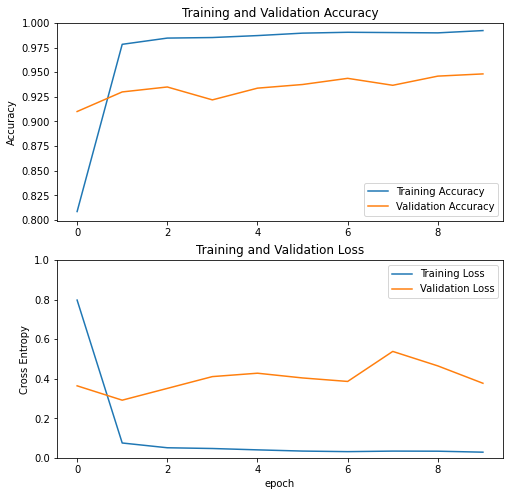

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tune the base model

### Un-freeze more layers

In [16]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [17]:
base_model.trainable = True
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

### Reconfigure the model

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 2, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 2, 2, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 131)               4323      
Total params: 2,630,979
Trainable params: 2,234,435
Non-trainable params: 396,544
_________________________________________________________________


In [20]:
print('Number of trainable weights = {}'.format(len(model.trainable_weights)))

Number of trainable weights = 58


### Continue training

In [21]:
history_fine = model.fit(train_generator,
                         steps_per_epoch=len(train_generator), 
                         epochs=5,
                         validation_data=val_generator,
                         validation_steps=len(val_generator))

Epoch 1/5
1058/1058 [==============================] - 62s 56ms/step - loss: 6.7897 - accuracy: 0.3573 - val_loss: 1.0206 - val_accuracy: 0.8095
Epoch 2/5
1058/1058 [==============================] - 58s 55ms/step - loss: 0.6361 - accuracy: 0.8196 - val_loss: 0.6520 - val_accuracy: 0.8633
Epoch 3/5
1058/1058 [==============================] - 58s 55ms/step - loss: 0.2380 - accuracy: 0.9277 - val_loss: 0.5152 - val_accuracy: 0.9006
Epoch 4/5
1058/1058 [==============================] - 58s 55ms/step - loss: 0.1081 - accuracy: 0.9661 - val_loss: 0.4363 - val_accuracy: 0.9194
Epoch 5/5
1058/1058 [==============================] - 59s 55ms/step - loss: 0.0640 - accuracy: 0.9793 - val_loss: 0.3801 - val_accuracy: 0.9343


### Review the new learning curves

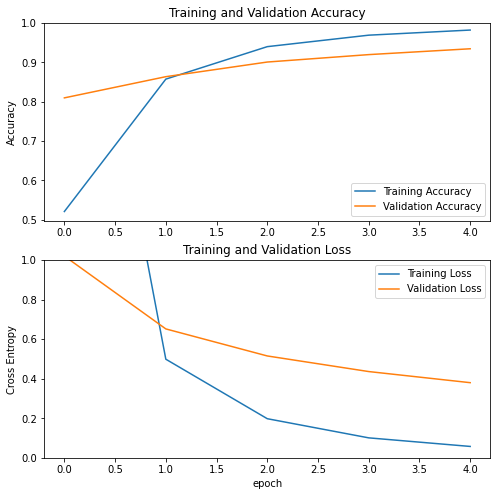

In [22]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Convert to TFLite

In [23]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('mobilenet_v2_1.0_224.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp9be3300d/assets


In [25]:
# A generator that provides a representative dataset
def representative_data_gen():
  dataset_list = tf.data.Dataset.list_files('fruits-360/*/*.jpg')
  for i in range(100):
    image = next(iter(dataset_list))
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
# This enables quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# This sets the representative dataset for quantization
converter.representative_dataset = representative_data_gen
# This ensures that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# For full integer quantization, though supported types defaults to int8 only, we explicitly declare it for clarity.
converter.target_spec.supported_types = [tf.int8]
# These set the input and output tensors to uint8 (added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

with open('mobilenet_v2_1.0_224_quant.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpy6n9w1ly/assets


INFO:tensorflow:Assets written to: /tmp/tmpy6n9w1ly/assets


### Compare the accuracy

In [26]:
batch_images, batch_labels = next(val_generator)

logits = model(batch_images)
prediction = np.argmax(logits, axis=1)
truth = np.argmax(batch_labels, axis=1)

keras_accuracy = tf.keras.metrics.Accuracy()
keras_accuracy(prediction, truth)

print("Raw model accuracy: {:.3%}".format(keras_accuracy.result()))

Raw model accuracy: 96.875%


In [27]:
def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  # Inputs for the TFLite model must be uint8, so we quantize our input data.
  # NOTE: This step is necessary only because we're receiving input data from
  # ImageDataGenerator, which rescaled all image data to float [0,1]. When using
  # bitmap inputs, they're already uint8 [0,255] so this can be replaced with:
  #   input_tensor[:, :] = input
  scale, zero_point = input_details['quantization']
  input_tensor[:, :] = np.uint8(input / scale + zero_point)

def classify_image(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  output = interpreter.get_tensor(output_details['index'])
  # Outputs from the TFLite model are uint8, so we dequantize the results:
  scale, zero_point = output_details['quantization']
  output = scale * (output - zero_point)
  top_1 = np.argmax(output)
  return top_1

interpreter = tf.lite.Interpreter('mobilenet_v2_1.0_224_quant.tflite')
interpreter.allocate_tensors()

# Collect all inference predictions in a list
batch_prediction = []
batch_truth = np.argmax(batch_labels, axis=1)

for i in range(len(batch_images)):
  prediction = classify_image(interpreter, batch_images[i])
  batch_prediction.append(prediction)

# Compare all predictions to the ground truth
tflite_accuracy = tf.keras.metrics.Accuracy()
tflite_accuracy(batch_prediction, batch_truth)
print("Quant TF Lite accuracy: {:.3%}".format(tflite_accuracy.result()))

Quant TF Lite accuracy: 89.062%


## Compile for the Edge TPU

In [28]:
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list

! sudo apt-get update

! sudo apt-get install edgetpu-compiler	

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1974  100  1974    0     0  19352      0 --:--:-- --:--:-- --:--:-- 19352
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [52.7 kB]
Get:5 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6,722 B]
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:9 https://develope

In [29]:
! edgetpu_compiler mobilenet_v2_1.0_224_quant.tflite

Edge TPU Compiler version 15.0.340273435

Model compiled successfully in 757 ms.

Input model: mobilenet_v2_1.0_224_quant.tflite
Input size: 3.08MiB
Output model: mobilenet_v2_1.0_224_quant_edgetpu.tflite
Output size: 3.15MiB
On-chip memory used for caching model parameters: 3.36MiB
On-chip memory remaining for caching model parameters: 4.45MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 72
Operation log: mobilenet_v2_1.0_224_quant_edgetpu.log
See the operation log file for individual operation details.


## Download the model

In [30]:
from google.colab import files

files.download('mobilenet_v2_1.0_224_quant_edgetpu.tflite')
files.download('fruit_labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Run the model on the Edge TPU

You can now run the model on your Coral device with acceleration on the Edge TPU.

To get started, try using your `.tflite` model with [this code for image classification with the TensorFlow Lite API](https://github.com/google-coral/tflite/tree/master/python/examples/classification). 

Just follow the instructions on that page to set up your device, copy the `mobilenet_v2_1.0_224_quant_edgetpu.tflite` and `fruit_labels.txt` files to your Coral Dev Board or device with a Coral Accelerator, and pass it a fruit photo like this:

```
python3 classify_image.py \
  --model mobilenet_v2_1.0_224_quant_edgetpu.tflite \
  --labels fruit_labels.txt \
  --input fruit.jpg
```

Check out more examples for running inference at [coral.ai/examples](https://coral.ai/examples/#code-examples/).